In [220]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV


In [221]:
# 加载数据
train_df = pd.read_csv("train.csv")
# 根据class4生成class2
# nonevent 为 0，event 为 1
# nonevent 为 0，II 为 1，Ib 为 2，Ia 为 3
train_df['class2'] = np.where(train_df['class4'] == 'nonevent', 'nonevent', 'event')
train_df['class2_label'] = (train_df['class2'] == 'event').astype(int)
train_df['class4_label'] = train_df['class4'].map({'nonevent': 0, 'II': 1, 'Ib': 2, 'Ia': 3})
target_labels = ['class2','class4','class2_label','class4_label']

print("\n--- 转换对照表  ---")
print(train_df[['class4', 'class2', 'class2_label','class4_label']].sample(10))

print(f"\n训练集形状: {train_df.shape}")



--- 转换对照表  ---
       class4    class2  class2_label  class4_label
128  nonevent  nonevent             0             0
312  nonevent  nonevent             0             0
294        II     event             1             1
47         Ib     event             1             2
235  nonevent  nonevent             0             0
73   nonevent  nonevent             0             0
422  nonevent  nonevent             0             0
330        Ib     event             1             2
244        Ib     event             1             2
423  nonevent  nonevent             0             0

训练集形状: (450, 107)


In [222]:
# 将X和y分离
train_X_df = train_df.drop(columns=target_labels)
train_y_df = train_df[target_labels]

print("train_X_df preview:")
print(train_X_df.head())

print("train_y_df preview:")
print(train_y_df.head())

train_X_df preview:
   id        date  partlybad  CO2168.mean  CO2168.std  CO2336.mean  \
0   0  2000-03-21      False   372.396757    0.752494   372.279392   
1   1  2000-03-23      False   372.889867    0.410639   372.769205   
2   2  2000-04-07      False   373.869464    0.655604   373.788580   
3   3  2000-04-09      False   376.006588    1.109789   375.888889   
4   4  2000-04-14      False   374.068239    1.257096   374.042330   

   CO2336.std  CO242.mean  CO242.std  CO2504.mean  ...  T672.mean  T672.std  \
0    0.716926  372.876081   0.817532   372.207838  ...   2.729459  2.041327   
1    0.380586  373.387815   0.478567   372.714967  ...  -1.259602  1.888414   
2    0.649312  374.356310   0.629567   373.737083  ...   2.079822  1.610976   
3    1.052157  376.779883   1.403241   375.806257  ...   3.499965  2.831278   
4    1.214805  374.725480   1.374858   374.048523  ...   1.421619  0.934736   

   T84.mean   T84.std  UV_A.mean   UV_A.std  UV_B.mean  UV_B.std   CS.mean  \
0  3.6

In [223]:
# 数据清洗部分
# id无用去掉
train_X_df = train_X_df.drop(columns=['id'])
# partlybad全是False 去掉
train_X_df = train_X_df.drop(columns=['partlybad'])
# 将date查分成年、月、日
train_X_df['year'] = train_X_df['date'].str[:4].astype(int)
train_X_df['month'] = train_X_df['date'].str[5:7].astype(int)
train_X_df['day'] = train_X_df['date'].str[8:].astype(int)
train_X_df = train_X_df.drop(columns=['date'])
# 去掉 PTG.mean 和 PTG.std
# train_X_df = train_X_df.drop(columns=['PTG.mean', 'PTG.std'])

print("train_X_df preview:")
print(train_X_df.head())


train_X_df preview:
   CO2168.mean  CO2168.std  CO2336.mean  CO2336.std  CO242.mean  CO242.std  \
0   372.396757    0.752494   372.279392    0.716926  372.876081   0.817532   
1   372.889867    0.410639   372.769205    0.380586  373.387815   0.478567   
2   373.869464    0.655604   373.788580    0.649312  374.356310   0.629567   
3   376.006588    1.109789   375.888889    1.052157  376.779883   1.403241   
4   374.068239    1.257096   374.042330    1.214805  374.725480   1.374858   

   CO2504.mean  CO2504.std   Glob.mean    Glob.std  ...   T84.std  UV_A.mean  \
0   372.207838    0.681111  127.050319  109.742153  ...  2.283825   6.237543   
1   372.714967    0.360547  215.997636  157.220231  ...  1.979027  11.626868   
2   373.737083    0.633824  348.039584  209.405812  ...  1.929516  16.688892   
3   375.806257    0.960352  365.411700  215.367254  ...  3.161601  17.456796   
4   374.048523    1.184708   58.798347   34.158414  ...  0.929537   4.279844   

    UV_A.std  UV_B.mean  UV_B.

In [224]:
# 检查NAN或0
def check_quality(df):    
    # NAN
    missing_count = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    
    # 0
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    zero_count = (df[numeric_cols] == 0).sum()
    zero_percent = ((df[numeric_cols] == 0).sum() / len(df)) * 100
    
    report = pd.DataFrame({
        'Missing_Count': missing_count,
        'Missing_%': missing_percent,
        'Zero_Count': zero_count,
        'Zero_%': zero_percent
    })
    
    # 按缺失率从高到低排序
    problematic_cols = report[(report['Missing_%'] > 0) | (report['Zero_%'] > 0)].sort_values('Missing_%', ascending=False)
    
    
    print(f"发现 {len(problematic_cols)} 个有潜在问题的列：")
    print(problematic_cols.head(20))
        
    return problematic_cols

train_report = check_quality(train_X_df)


发现 3 个有潜在问题的列：
          Missing_Count  Missing_%  Zero_Count    Zero_%
PTG.mean              0        0.0          43  9.555556
PTG.std               0        0.0          43  9.555556
SWS.std               0        0.0           1  0.222222


发现了PTG的数据有异常，后期训练的时候可以有选择的去掉异常值

In [225]:
# TODO 降维

In [226]:
# 8:2划分训练集和验证集
train_X_df, val_X_df, train_y_df, val_y_df = train_test_split(
    train_X_df, train_y_df['class2_label'], test_size=0.2, random_state=42
)
# 展示训练集和验证集的形状
print(f"训练集形状: {train_X_df.shape}")
print(f"验证集形状: {val_X_df.shape}")
print(f"训练集标签形状: {train_y_df.shape}")
print(f"验证集标签形状: {val_y_df.shape}")

训练集形状: (360, 103)
验证集形状: (90, 103)
训练集标签形状: (360,)
验证集标签形状: (90,)


In [227]:
# 3种模型对比：逻辑回归，随机森林，XGBoost
def calculate_metrics(y_true, y_pred_class, y_pred_proba):
    """
    计算二分类准确率和困惑度
    y_true: 真实标签 (0或1)
    y_pred_class: 预测类别 (0或1)
    y_pred_proba: 预测为1(Event)的概率
    """
    # 1. 计算准确率
    acc = accuracy_score(y_true, y_pred_class)
    
    # 2. 计算困惑度 (Perplexity)
    prob_correct = np.where(y_true == 1, y_pred_proba, 1 - y_pred_proba)
    prob_correct = np.clip(prob_correct, 1e-15, 1 - 1e-15) 
    perplexity = np.exp2(-np.mean(np.log2(prob_correct)))

    return acc, perplexity


--- 1. 逻辑回归 ---
C Value    | Accuracy   | Perplexity
------------------------------------
0.98       | 0.9111     | 1.3477
0.981      | 0.9111     | 1.3482
0.982      | 0.9111     | 1.3482
0.983      | 0.9111     | 1.3483
0.984      | 0.9111     | 1.3477
0.985      | 0.9111     | 1.3481
0.986      | 0.9111     | 1.3481
0.987      | 0.9111     | 1.3476
0.988      | 0.9111     | 1.3477
0.989      | 0.9111     | 1.3478
0.99       | 0.9111     | 1.3482
0.991      | 0.9111     | 1.3477
0.992      | 0.9111     | 1.3476
0.993      | 0.9111     | 1.3483
0.994      | 0.9111     | 1.3476
0.995      | 0.9111     | 1.3477
0.996      | 0.9111     | 1.3476
0.997      | 0.9111     | 1.3479
0.998      | 0.9111     | 1.3480
0.999      | 0.9111     | 1.3475
1.0        | 0.9111     | 1.3476
1.001      | 0.9111     | 1.3478
1.002      | 0.9111     | 1.3486
1.003      | 0.9111     | 1.3478
1.004      | 0.9111     | 1.3478
1.005      | 0.9111     | 1.3477
1.006      | 0.9111     | 1.3478
1.007      | 0.911

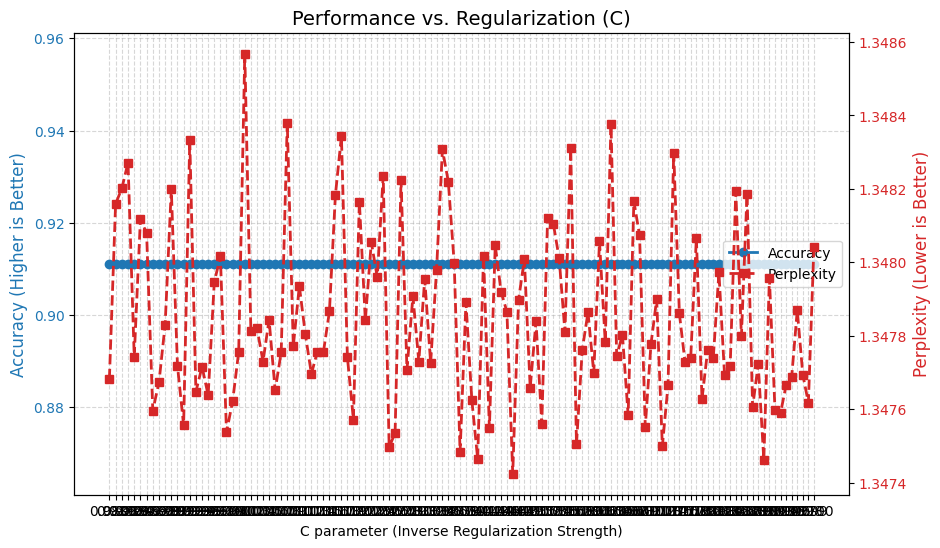


🏆 最佳参数: C = 1.047
   对应 Accuracy: 0.9111
   对应 Perplexity: 1.3474


In [228]:
print("\n--- 1. 逻辑回归 ---")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X_df)
X_val_scaled = scaler.transform(val_X_df)

c_values = [round(x, 3) for x in np.arange(0.98, 1.1, 0.001)]

results = []

print(f"{'C Value':<10} | {'Accuracy':<10} | {'Perplexity':<10}")
print("-" * 36)

# --- 循环训练 ---
for c in c_values:
    # 初始化模型
    lr = LogisticRegression(C=c, random_state=42, max_iter=1000, solver='lbfgs')
    
    # 训练
    lr.fit(X_train_scaled, train_y_df)
    
    # 预测
    pred_class = lr.predict(X_val_scaled)
    pred_proba = lr.predict_proba(X_val_scaled)[:, 1]
    
    # 计算指标 (调用你刚才修复好的 calculate_metrics 函数)
    acc, perp = calculate_metrics(val_y_df, pred_class, pred_proba)
    
    # 存入列表
    results.append({
        'C': c,
        'Accuracy': acc,
        'Perplexity': perp
    })
    
    print(f"{c:<10} | {acc:.4f}     | {perp:.4f}")

# --- 转换为 DataFrame 方便绘图 ---
res_df = pd.DataFrame(results)

# --- 绘图 (双轴图) ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# 设置 x 轴为对数坐标 (因为 C 变化范围大)
ax1.set_xscale('log')
ax1.set_xlabel('C parameter (Inverse Regularization Strength)')
ax1.set_xticks(c_values)
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter()) # 显示具体数字而非 10^x

# 绘制左轴：准确率 (越高越好)
color = 'tab:blue'
ax1.set_ylabel('Accuracy (Higher is Better)', color=color, fontsize=12)
line1 = ax1.plot(res_df['C'], res_df['Accuracy'], marker='o', color=color, label='Accuracy', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# 绘制右轴：困惑度 (越低越好)
ax2 = ax1.twinx()  # 共享 x 轴
color = 'tab:red'
ax2.set_ylabel('Perplexity (Lower is Better)', color=color, fontsize=12)
line2 = ax2.plot(res_df['C'], res_df['Perplexity'], marker='s', color=color, linestyle='--', label='Perplexity', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

plt.title('Performance vs. Regularization (C)', fontsize=14)
plt.show()

# --- 找出最佳 C 值 ---
best_row = res_df.loc[res_df['Perplexity'].idxmin()]
print(f"\n🏆 最佳参数: C = {best_row['C']}")
print(f"   对应 Accuracy: {best_row['Accuracy']:.4f}")
print(f"   对应 Perplexity: {best_row['Perplexity']:.4f}")

C= 1.047为最好 1000次就收敛了

对应 Accuracy: 0.9111
对应 Perplexity: 1.3474

但这只是在random=42时的结果，而且在测试集上未必完全对用

--- 开始测试 n_estimators (树的数量) ---
Fitting 3 folds for each of 41 candidates, totalling 123 fits
训练完成！


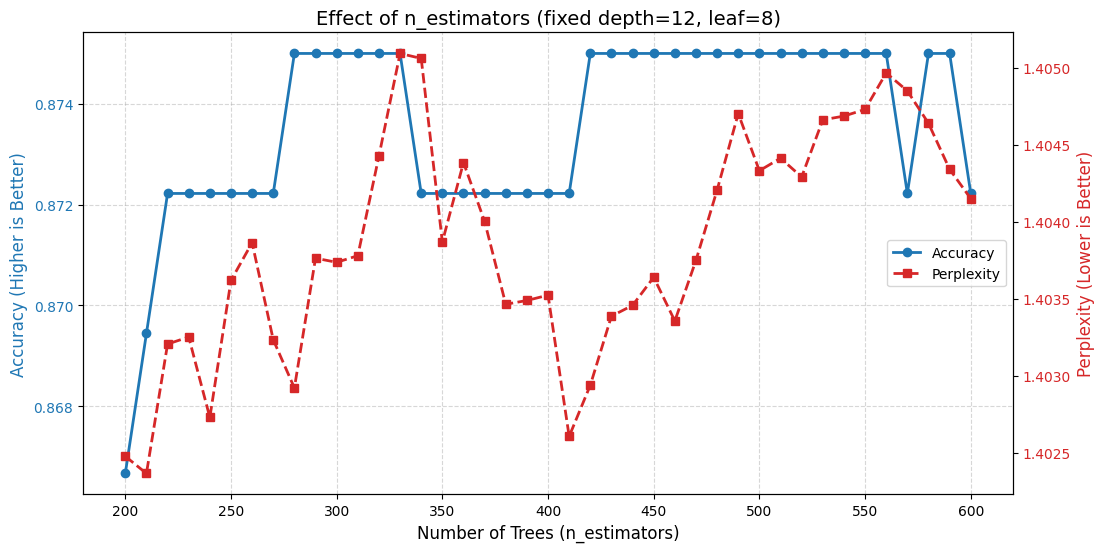


🏆 最佳树数量:
   n_estimators: 210
   对应 Accuracy: 0.8694
   对应 Perplexity: 1.4024


In [229]:


# --- 1. 准备数据 ---
X_train = train_X_df
y_train = train_y_df.values.ravel() if hasattr(train_y_df, 'values') else train_y_df

print("--- 开始测试 n_estimators (树的数量) ---")

# --- 2. 定义参数网格 ---
# ⚠️ 重要提示：请将 max_depth 和 min_samples_leaf 替换为你上一步热力图中找到的最佳值！
# 这里我暂时用 12 和 8 作为示例 (这是一个通常不错的组合)
fixed_depth = 12 
fixed_leaf = 8

param_grid = {
    # 变量：我们想测试的树的数量范围
    'n_estimators': list(range(200, 601, 10)),
    
    # 固定参数：
    'max_depth': [fixed_depth],
    'min_samples_leaf': [fixed_leaf],
    'max_features': ['sqrt']
}

# --- 3. 初始化并训练 ---
scoring_metrics = {
    'Accuracy': 'accuracy', 
    'LogLoss': 'neg_log_loss'
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring=scoring_metrics,
    refit='LogLoss',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("训练完成！")

# --- 4. 提取结果 ---
results_df = pd.DataFrame(grid_search.cv_results_)

plot_df = results_df[[
    'param_n_estimators', 
    'mean_test_Accuracy', 
    'mean_test_LogLoss'
]].copy()

# 计算困惑度
plot_df['LogLoss'] = -plot_df['mean_test_LogLoss']
plot_df['Perplexity'] = np.exp(plot_df['LogLoss'])
plot_df['n_estimators'] = plot_df['param_n_estimators'].astype(int)

# --- 5. 绘制双轴折线图 (Dual Axis Line Plot) ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# 设置 X 轴
ax1.set_xlabel('Number of Trees (n_estimators)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.5)

# --- 左轴：准确率 (蓝色) ---
color_acc = 'tab:blue'
ax1.set_ylabel('Accuracy (Higher is Better)', color=color_acc, fontsize=12)
line1 = ax1.plot(plot_df['n_estimators'], plot_df['mean_test_Accuracy'], 
                 marker='o', color=color_acc, label='Accuracy', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color_acc)

# --- 右轴：困惑度 (红色) ---
ax2 = ax1.twinx()  # 共享 X 轴
color_perp = 'tab:red'
ax2.set_ylabel('Perplexity (Lower is Better)', color=color_perp, fontsize=12)
line2 = ax2.plot(plot_df['n_estimators'], plot_df['Perplexity'], 
                 marker='s', linestyle='--', color=color_perp, label='Perplexity', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color_perp)

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')

plt.title(f'Effect of n_estimators (fixed depth={fixed_depth}, leaf={fixed_leaf})', fontsize=14)
plt.show()

# --- 输出最佳结果 ---
best_idx = grid_search.best_index_
print(f"\n🏆 最佳树数量:")
print(f"   n_estimators: {results_df.loc[best_idx, 'param_n_estimators']}")
print(f"   对应 Accuracy: {results_df.loc[best_idx, 'mean_test_Accuracy']:.4f}")
print(f"   对应 Perplexity: {np.exp(-results_df.loc[best_idx, 'mean_test_LogLoss']):.4f}")

🏆 综合最佳参数 (基于 LogLoss):

   Max Depth: 5

   Min Samples Leaf: 4

   对应 Accuracy: 0.8750
   对应 Perplexity: 1.3955

   改变n_estimators还会有结果变化，但是影响不大

--- 开始 XGBoost 参数网格搜索 (Accuracy & LogLoss) ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits
训练完成！


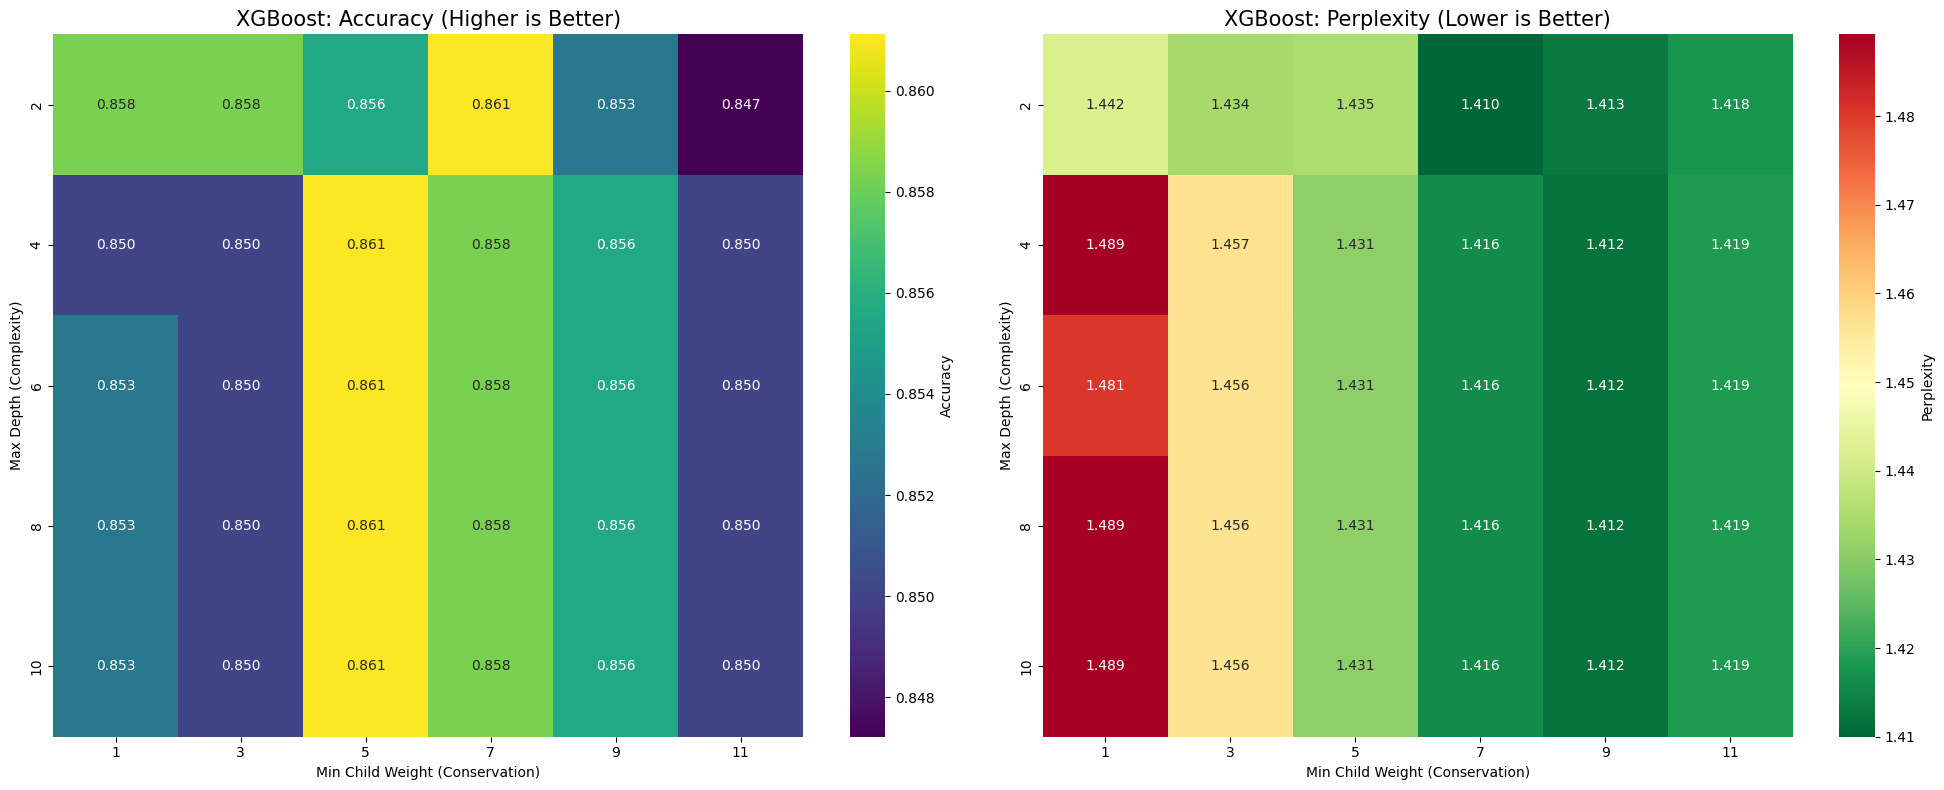


🏆 XGBoost 最佳参数 (基于 LogLoss):
   Max Depth: 2
   Min Child Weight: 7
   对应 Accuracy: 0.8611
   对应 Perplexity: 1.4100


In [230]:


print("--- 开始 XGBoost 参数网格搜索 (Accuracy & LogLoss) ---")

# 1. 准备数据
X_train = train_X_df
y_train = train_y_df.values.ravel() if hasattr(train_y_df, 'values') else train_y_df

# 2. 定义参数网格
# 注意：XGBoost 的深度通常比随机森林要浅很多 (3-10是常见范围)
param_grid = {
    # 固定参数 (为了控制计算时间)
    'n_estimators': [200], 
    'learning_rate': [0.05], 
    
    # 变量参数：我们需要调节这两个来平衡 准确率 vs 困惑度
    'max_depth': [2, 4, 6, 8, 10], 
    'min_child_weight': [1, 3, 5, 7, 9, 11] # 类似于 min_samples_leaf，越大越保守
}

# 3. 初始化模型与搜索
# use_label_encoder=False 消除警告
# eval_metric='logloss' 优化困惑度
xgb = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42, 
    n_jobs=-1,
    verbosity=0 # 静默模式
)

scoring_metrics = {
    'Accuracy': 'accuracy', 
    'LogLoss': 'neg_log_loss'
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring=scoring_metrics,
    refit='LogLoss',
    verbose=1,
    n_jobs=-1
)

# 4. 训练
grid_search_xgb.fit(X_train, y_train)
print("训练完成！")

# --- 5. 提取结果并绘图 ---
results_df = pd.DataFrame(grid_search_xgb.cv_results_)

# 提取数据
plot_df = results_df[[
    'param_max_depth', 
    'param_min_child_weight', 
    'mean_test_Accuracy', 
    'mean_test_LogLoss'
]].copy()

# 转换指标
plot_df['LogLoss'] = -plot_df['mean_test_LogLoss']
plot_df['Perplexity'] = np.exp(plot_df['LogLoss'])
plot_df['max_depth'] = plot_df['param_max_depth'].astype(int)
plot_df['min_child_weight'] = plot_df['param_min_child_weight'].astype(int)

# 准备绘图透视表
pivot_acc = plot_df.pivot(index='max_depth', columns='min_child_weight', values='mean_test_Accuracy')
pivot_perp = plot_df.pivot(index='max_depth', columns='min_child_weight', values='Perplexity')

# 绘制双热力图
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 图 1: 准确率 (Accuracy)
sns.heatmap(pivot_acc, ax=axes[0], annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'Accuracy'})
axes[0].set_title('XGBoost: Accuracy (Higher is Better)', fontsize=15)
axes[0].set_xlabel('Min Child Weight (Conservation)')
axes[0].set_ylabel('Max Depth (Complexity)')

# 图 2: 困惑度 (Perplexity)
sns.heatmap(pivot_perp, ax=axes[1], annot=True, fmt=".3f", cmap="RdYlGn_r", cbar_kws={'label': 'Perplexity'})
axes[1].set_title('XGBoost: Perplexity (Lower is Better)', fontsize=15)
axes[1].set_xlabel('Min Child Weight (Conservation)')
axes[1].set_ylabel('Max Depth (Complexity)')

plt.tight_layout()
plt.show()

# --- 输出最佳结果 ---
best_idx = grid_search_xgb.best_index_
print(f"\n🏆 XGBoost 最佳参数 (基于 LogLoss):")
print(f"   Max Depth: {results_df.loc[best_idx, 'param_max_depth']}")
print(f"   Min Child Weight: {results_df.loc[best_idx, 'param_min_child_weight']}")
print(f"   对应 Accuracy: {results_df.loc[best_idx, 'mean_test_Accuracy']:.4f}")
print(f"   对应 Perplexity: {np.exp(-results_df.loc[best_idx, 'mean_test_LogLoss']):.4f}")